In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/ #copy api key ---- depend on your directory -- my directory is .../colab/..
!kaggle datasets list
!kaggle competitions download -c fake-news

In [5]:
!unzip /content/fake-news.zip

Archive:  /content/fake-news.zip
  inflating: submit.csv              
  inflating: test.csv                
  inflating: train.csv               


# SETUP

In [ ]:
!pip install -qU pythainlp
!pip install -q gradio attacut emoji
!pip install -qU sentence-transformers

In [7]:
import pandas as pd
import numpy as np
from pythainlp import word_tokenize
from tqdm import tqdm_notebook
from attacut import tokenize
import re
import emoji

In [8]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

In [17]:
import pandas as pd
df_train = pd.read_csv('/content/train.csv')
df_train

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


from matplotlib import pyplot as plt
_df_0['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='id', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('label')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [18]:
df_train = df_train.dropna()

In [19]:
df_train['label'].value_counts()

0    10361
1     7924
Name: label, dtype: int64

# Preprocess

In [20]:
class preprocess():
    def __init__(self):
        pass

    def replace_url(self,text):
        URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}
                          ]+|
                          [^\s()]*?\)|
                          )+(?:
                          [^\s()]*?\)|
                          |[^\s`!()
                          {};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
        return re.sub(URL_PATTERN, 'xxurl', text)

    def replace_rep(self,text):
        def _replace_rep(m):
            c,cc = m.groups()
            return f'{c}xxrep'
        re_rep = re.compile(r'(\S)(\1{2,})')
        return re_rep.sub(_replace_rep, text)

    def ungroup_emoji(self,toks):
        res = []
        for tok in toks:
            if emoji.emoji_count(tok) == len(tok):
                for char in tok:
                    res.append(char)
            else:
                res.append(tok)
        return res

    def process_text(self,text):
        res = text.lower().strip()
        res = self.replace_url(res)
        res = self.replace_rep(res)

        res = [word for word in word_tokenize(res) if word and not re.search(pattern=r"\s+", string=word)]
        res = self.ungroup_emoji(res)

        return res

prepro = preprocess()

In [21]:
df_label_0 = df_train[df_train['label'] == 0]
df_label_1 = df_train[df_train['label'] == 1]

count_label_0 = len(df_label_0)
count_label_1 = len(df_label_1)

min_count = min(count_label_0, count_label_1)

df_label_0 = df_label_0.sample(n=min_count)
df_label_1 = df_label_1.sample(n=min_count)
concatenated_df = pd.concat([df_label_0, df_label_1], axis=0)

In [23]:
import csv
Xtrain = []
Ytrain = []
for context,labels in zip(concatenated_df["text"],concatenated_df['label']):
   comment = ' '.join(prepro.process_text(context))
   Xtrain.append(comment)
   Ytrain.append(labels)
len(Xtrain) , len(Ytrain)

(15848, 15848)

In [24]:
embeddings = model.encode(Xtrain)
Ytrain = np.array(Ytrain)

In [25]:
embeddings.shape , Ytrain.shape

((15848, 384), (15848,))

# Split Data

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings, Ytrain, test_size=0.2, random_state=19)
len(y_train) , len(y_test)

(12678, 3170)

# Train MLPClassifier

In [27]:
from sklearn.neural_network import MLPClassifier
neural_network = ( 128,64, 64, 128, 64, 32, 16,)
mlp = MLPClassifier(max_iter=1000 , activation='relu', learning_rate_init=0.001,solver='adam', alpha=1e-3,
                    hidden_layer_sizes=neural_network, random_state=42)
mlp.fit(X_train, y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(128, 64, 64, 128, 64, 32, 16),
              max_iter=1000, random_state=42)

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, mlp.predict(X_test))

0.8649842271293375

# Plot

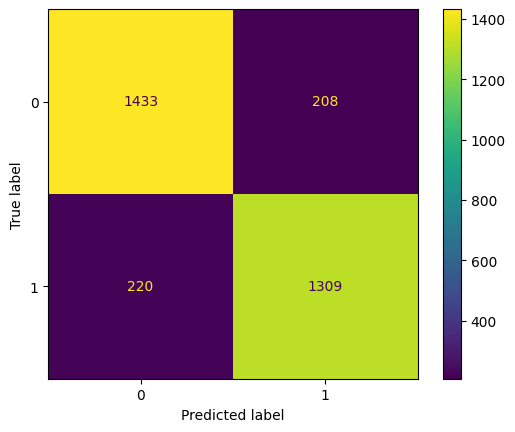

In [31]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, mlp.predict(X_test))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

# Predict

In [43]:
df_test = pd.read_csv('/content/test.csv')
df_test

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...
...,...,...,...,...
5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...
5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...
5197,25997,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...
5198,25998,300 US Marines To Be Deployed To Russian Borde...,NaN,« Previous - Next » 300 US Marines To Be Deplo...


In [44]:
df_submit = pd.read_csv('/content/submit.csv')
df_submit

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1
...,...,...
5195,25995,0
5196,25996,1
5197,25997,0
5198,25998,1


In [45]:
import tqdm

In [47]:
for idx,context in tqdm.tqdm(enumerate(df_test["text"])):
  try:
    context = ' '.join(prepro.process_text(context))
    result = mlp.predict(model.encode([context]))[0]
    df_submit["label"][idx] = result
  except:
    print(idx)

589it [02:19,  5.04it/s]

589


626it [02:29,  3.46it/s]

626


980it [03:45,  6.47it/s]

978


2257it [08:31,  6.58it/s]

2257


2894it [10:52,  6.16it/s]

2892


4736it [17:40,  6.28it/s]

4736


5092it [19:02,  3.55it/s]

5092


5200it [19:25,  4.46it/s]


In [48]:
df_submit.to_csv("summition1.csv", index=False, encoding='utf-8')